In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import sys
sys.path.append('demo_python_backend_files')
sys.path.append('demo_datasets')
import csv
import pandas as pd
import sparse_feature_selection_methods as my

# Feature Selection via L1-norm Regularization

In this notebook we discuss feature selection via L1-norm regularization, as a complement to our discussion of regularization in the textbook.

>The content of this notebook is supplementary material for the textbook Machine Learning Refined (Cambridge University Press, 2016). Visit http://www.mlrefined.com for free chapter downloads and tutorials, and [our Amazon site here](https://www.amazon.com/Machine-Learning-Refined-Foundations-Applications/dp/1107123526/ref=sr_1_1?ie=UTF8&qid=1474491657&sr=8-1&keywords=machine+learning+refined) for details regarding a hard copy of the text.

### Regularization: A quick refresher

In **Sections 3.3** and **7.3** of Machine Learning Refined, available for download [here](http://mlrefined.wix.com/home-page#!download-sample-chapters/cjg9), we introduced the concept of regularization and discussed two major issues with machine learning models that regularization helps ameliorate:

**1. Saddle points/flat regions of non-convex cost functions:** many machine learning cost functions -including artificial neural networks- are non-convex and as a result may have flat regions like the ones shown below. 
<img src="demo_images/regularization_before.png" width=200 height=350/>

These flat regions are problematic because numerical optimization schemes (like gradient descent and its variants) can easily get stuck in them, leading to poor results (see Section 3.3 for more dtails). Adding a convex regularizer, like the L2-norm squared, to the objective function $g(\mathbf{w})$

$$g(\mathbf{w})+\lambda\left\Vert \mathbf{w}\right\Vert _{2}^{2}$$

can unflatten these flat regions without severely changing the minimum locations (with small $\lambda$), as illustrated below.

<img src="demo_images/regularization_after.png" width=200 height=350/>

**2. Overfitting:** as discussed in Section 7.3 of the book, when the predictive model is too *flexible* one can easily overfit to the training data by making the corresponding objective function $g(\mathbf{w})$ too small. Adding a regularizer to the objective function in this case helps avoid overfitting as making the the original objective too small will most likely result in a rather large regularizer evaluation, thereby striking a balance between fidelity to the training data and model complexity. 


Although in the book we based our discussion of regularization on the L2-norm squared regularizer, which is by far the most widely used regularizer due to its simplicity and ease of use, there are other regularizers being used in machine learning today, each bringing a certain characteristic to the models they regularize. For instance an L1-norm regularizer, denoted by $\left\Vert \mathbf{w}\right\Vert _{1}$ and defined as $\left\Vert \mathbf{w}\right\Vert _{1}=\underset{i}{\sum}\left|w_{i}\right|$

promotes sparsity on the its input vector $\mathbf{w}$. In other words, the minimizer of

$$g(\mathbf{w})+\lambda\left\Vert \mathbf{w}\right\Vert _{1}$$

will have very few nonzero entries. Exploring why **L1-regularization promotes sparse solutions** is outside the scope of this notebook, but the interested reader is encouraged to see here. Accepting it as a fact for the moment, we see next how it can be leveraged in certain machine learning applications.   


### Sparse feature selection: A simulated experiment

In some machine learning applications, you may face the following scenario: You're given a gargantuan number of input features, of which only a small number actually contribute to the target variable you're trying to predict. For example in Genome-Wide Association (GWA) studies we aim to predict a quantitative biological trait like cholesterol level (**regression**) or diagnose a disease like breast cancer (**classification**) using more than 20,000 genetic markers (**features**) across the human genome. It is known among biologists that the vast majority of genes have little or no effect on the presence or severity of most diseases. L1-regualirized models are therefore used in situations like this, allowing only a few of the thousands of possible genes to be selected by the model (**sparse feature selection**), resulting in predictive models with enhanced accuracy and human interpretability.

<img src="demo_images/GWA.png" width=700 height=350/>



In what follows we use a simulated GWA dataset wherein gene expression levels of 20 patients with breast cancer and 20 healthy subjects are collected. For this simulated experiment we limit the number of genes to 100 and further assume that only two of those, **gene #33** and **gene #66**, are actually relevant in diagnosing breast cancer. Clearly, our machine learning model is not prevy to this last piece of information!

In [2]:
#loading simulatd data
data = np.asarray(pd.read_csv("demo_datasets/simulated_gene_data.csv", header=None))
X = data[:-1,:] # feature matrix 
y = data[-1:].reshape((data.shape[1],)) # labels: 0 for helathy and 1 for afflicted

Notice that using only genes #33 and #66 we are able to separate the two classes with relatively high accuracy.

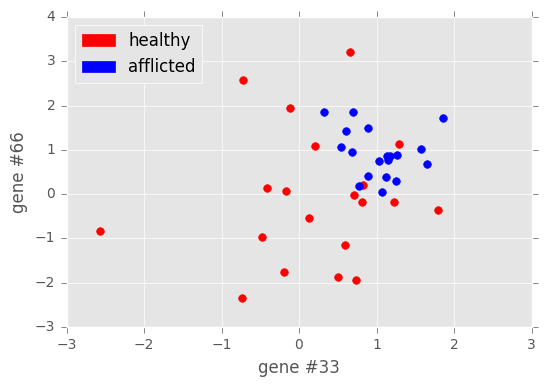

In [3]:
my.plot_genes(X, 33, 66)

This is not the case with any other pair of genes. For example, using genes #10 and #20 we get 

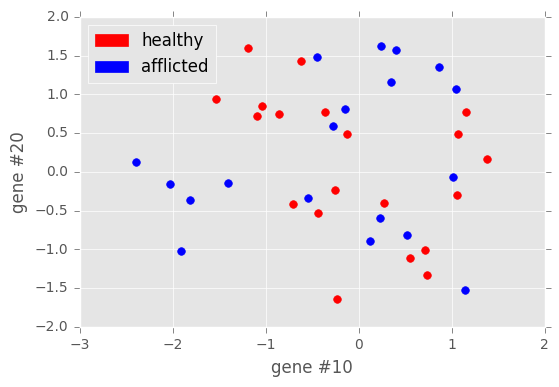

In [4]:
my.plot_genes(X, 10, 20)

We are now ready to classfiy this data. Lets start with a regular logistic regression model with no regularization characterized by the following optimization problem

$$\begin{aligned}\underset{b,\mathbf{w}}{\mbox{minimize}} & \,\ \textrm{log}\left(1+e^{-y_{p}\left(b+\mathbf{x}_{p}^{T}\mathbf{w}\right)}\right)
\end{aligned}$$

In [5]:
w = my.logistic_regression(X, y)

The parameter vector $\mathbf{w}$ now contains the logistic regression weights associated with each of the genes in our simulated data. Lets visualize this weight vector:

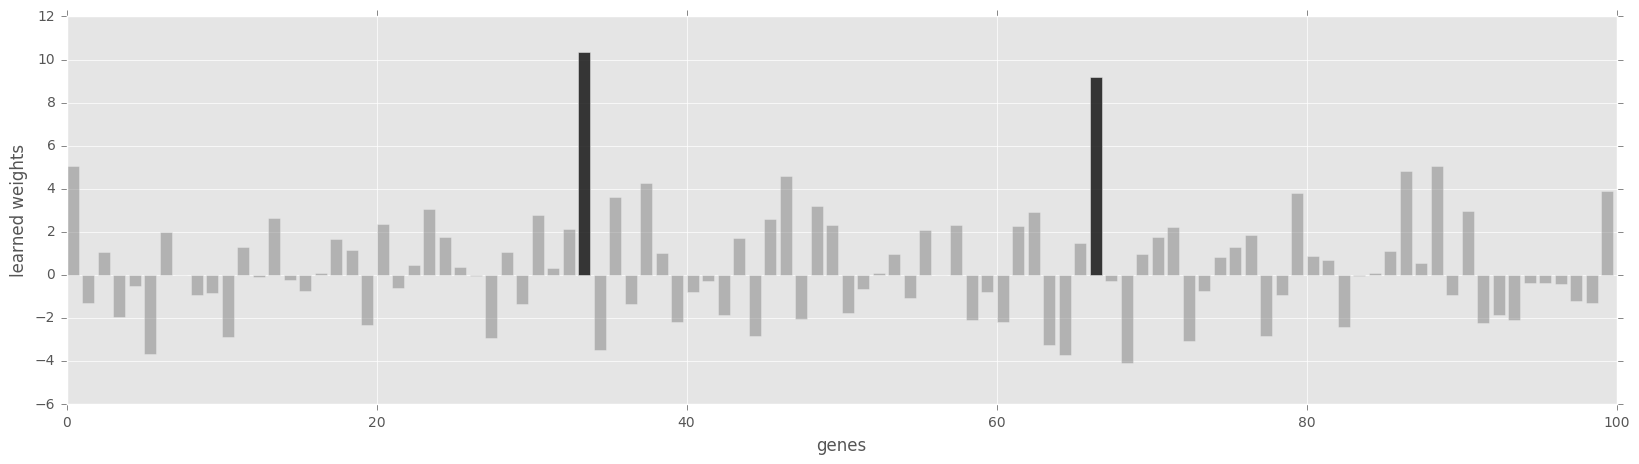

In [6]:
my.plot_weights(w, 33, 66)

Note that although the 33rd and 66th entries of $\mathbf{w}$ (colored in darker grey in the figure above) have large magnitudes (desirable), the rest of the genes also contribute to the classifier via their non-zero weights (undesirable). Employing L1-regularized logistic regression we wish to arrive at a model that automatically selects the relevant genes, and those alone.
The L1-regularized logistic regression problem takes the form 

$$\begin{aligned}\underset{b,\mathbf{w}}{\mbox{minimize}} & \,\ \textrm{log}\left(1+e^{-y_{p}\left(b+\mathbf{x}_{p}^{T}\mathbf{w}\right)}\right)
+\lambda\left\Vert \mathbf{w}\right\Vert _{1}\end{aligned}$$

where the regularization parameter $\lambda$ controls how sparse we want the weight vector be.

Note that unlike the regular logistic regression model, to solve the L1-regularized version we cannot apply gradient descent, since the presence of the L1-norm makes the objective function non-differenetiable. Luckily, there are a host of numerical schemes that can be applied to problems like this. We use here one such algorithm - the accelerated proximal gradient method. See [here](pdfs/proximal_gradient_techniques.pdf) for more details regarding this algorithm.    

Setting $\lambda$ to .0005, we now run the algorithm and visualize the resulting weight vector: 

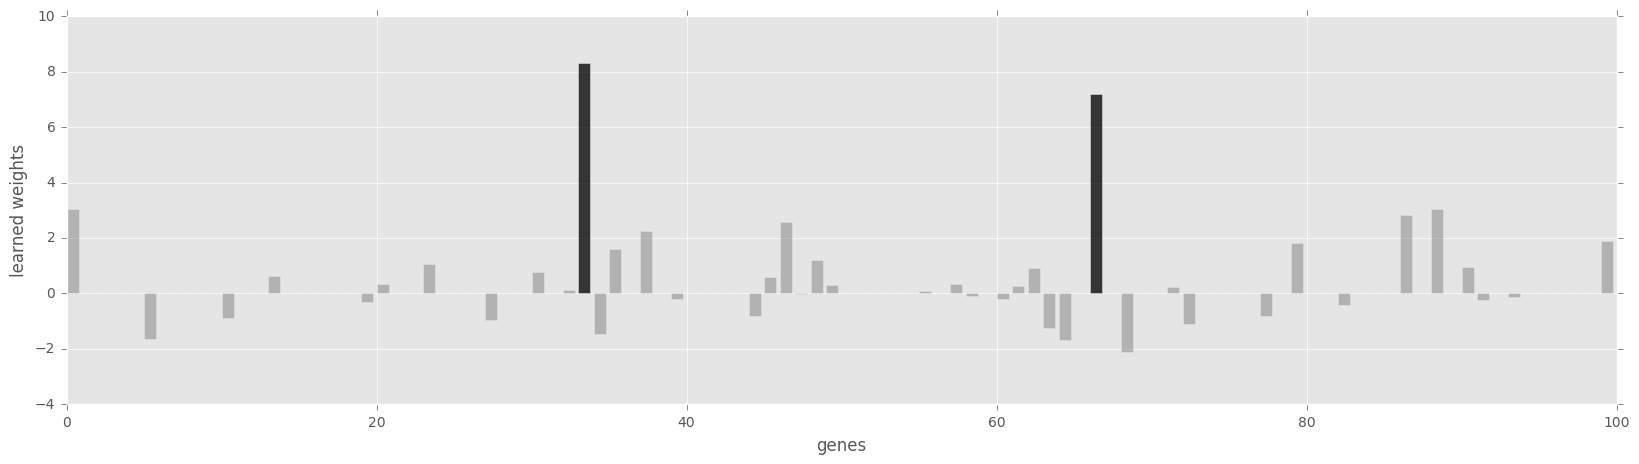

In [7]:
lam = .0005
w = my.L1_logistic_regression(X, y, lam)
my.plot_weights(w, 33, 66)

Notice that many entries of $\mathbf{w}$ are now zero. By cranking up $\lambda$ we can get sparser results.  

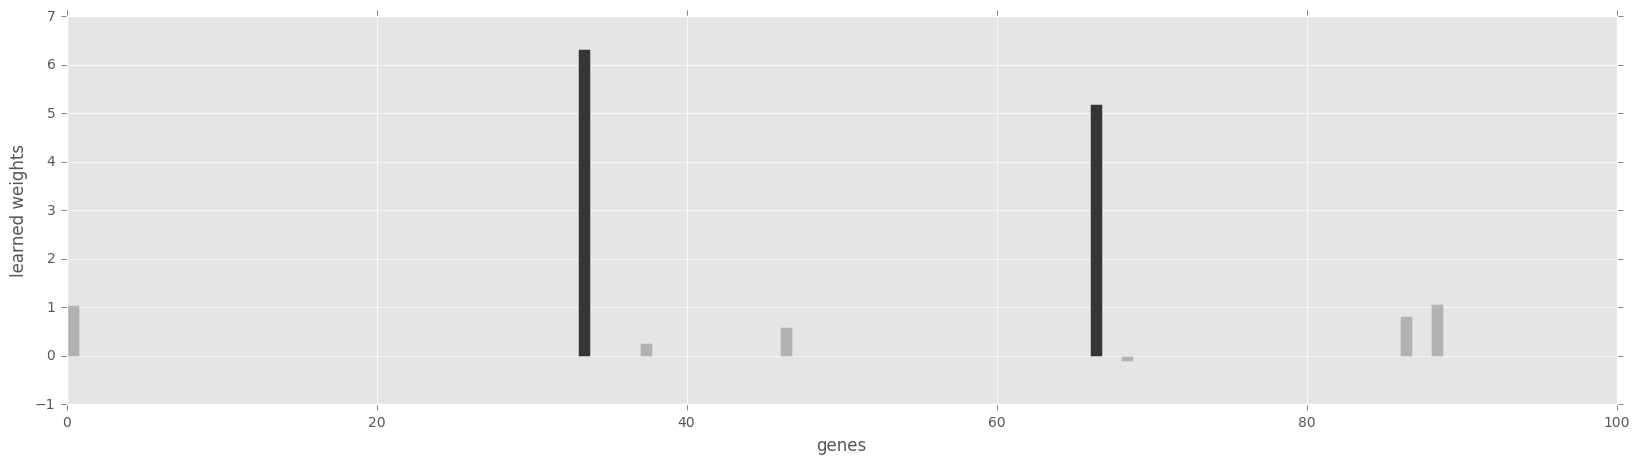

In [8]:
lam = .001
w = my.L1_logistic_regression(X, y, lam)
my.plot_weights(w, 33, 66)

Finally, with $\lambda=.002$ which we found by trial and error (but can be set more systematically using cross-validation) we get: 

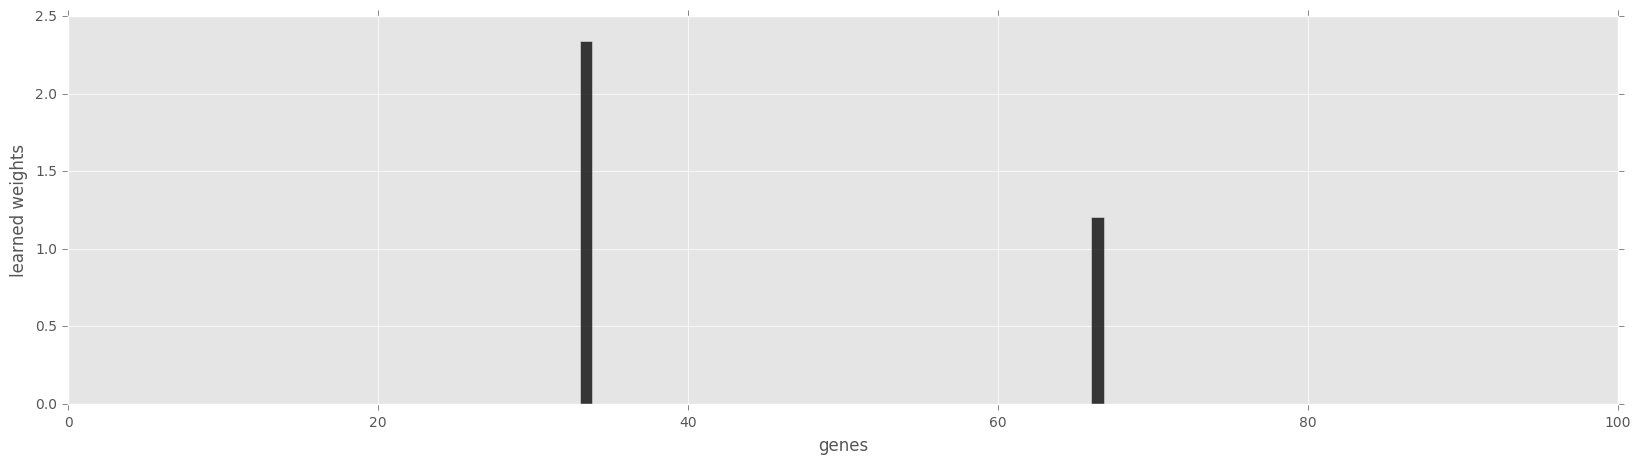

In [9]:
lam = .002
w = my.L1_logistic_regression(X, y, lam)
my.plot_weights(w, 33, 66)